# Solving ODEs and ODE systems

Solving Ordinary Differential Equations is one of the most common use cases for scientific computing in engineering applications. 

The Julia package [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) is one of the biggest selling points of the language. It offers an unparalled range of solvers, all using the same interface^[So changing the solver does not require any changes in the definition of the problem, even when moving between ODEs, DAEs and SDAEs.].

## Example: 4-Element Windkessel Model




{{< downloadthis ODEsolver.ipynb dname=ODEsolver label="Download Jupyter Notebook" >}}







The windkessel model is a common model for the pressure response of the vascular system (blood circulation) to a periodic, pulsing flow waveform [@Westerhof2019].

Here we are going to work with the 4-Element windkessel model [@Stergiopulos1999], comprising a flow source (time dependent flow rate), two resistors for characteristic Resistance of the near vessel (aorta), $R_{c}$, and systemic (peripheral) resistance, $R_{p}$, a compliance (capacitance) $C$, representing the blood storage capacity of the peripheral vessels, and an inductance $L_p$, representing the inertia in the proximal, large vessel, e.g., the aorta.

The pressures in this circuit - $p_{1}$ before, and $p_{2}$ after the proximal L-R element - are described by the system of ODEs:

$$
\frac{d p_{1}}{d t}  =  - \frac{R_{c}}{L_{p}} p_{1} + \left( \frac{R_{c}}{L_{p}} - \frac{1}{R_{p} C} \right) p_{2} 
+ R_{c} \frac{d I(t)}{d t} + \frac{I(t)}{C} 
$$ {#eq-wk4-1}

$$
\frac{d p_{2}}{d t}  =  - \frac{1}{R_{p} C} p_{2} + \frac{I(t)}{C} 
$$ {#eq-wk4-2}

<!-- Source: file:///home/thor/Documents/Research/SaxtonPhD/0D-ModellingInJulia_files/images/wk4.drawio.png, accessed: Sun Mar  5 16:01:01 2023 -->
![4-Element Windkessel Model](./images/images_for_ODEsolver.qmd/wk4.drawio.png){#fig-4wk}

In order to implement this model, we need to load the required modules. We use `DifferentialEquations`, `Plots`, and `ForwardDiff` for the time-derivative $\frac{\partial I}{\partial t}$:


In [2]:
using DifferentialEquations, ForwardDiff, Plots

In [3]:
#| echo: false
#| output: false

plotlyjs();

WebIO._IJuliaInit()

The input waveform is a generic half-period of a sine-wave with a systolic (ejection) time of $t_{syst} = 0.4 T$, with $T=1\ \mathrm{s}$ period-time (60 beats per minute). The dicrotic notch is modelled by running the sine into the negative for $t_{dicr} = 0.03\ \mathrm{s}$:

\begin{equation}
    I = 
    \begin{cases}
        I_{min} + (I_{max} - I_{min})  \sin \left(\frac{\pi}{t_{syst}} t \right) & \text{if } t < (t_{syst} + t_{dicr})\\
        I_{min} & \text{else} 
    \end{cases}
\end{equation}


In Julia, this function is implemented as^[Note that we use `const` here to define the parameters. Julia does suffer in performance, when global variables are used, since these break type stability in the multiple dispatch. Making these parameter constant fixes their type. We should really be using these parameters in the function definition, or use a lambda function here.]:


In [4]:
#| output: false
 
# max and min volume flow in ml/s
const max_i = 425
const min_i = 0.0

# period time
const T = 1.0

# Syst. Time in s
const systTime = 2 / 5 * T

# Dicrotic notch time in s
const dicrTime = 0.03

function I(t)
    # implicit conditional using boolean multiplicator
    # sine waveform
    t = t - T * (t ÷ T)

    return ((max_i - min_i) * sin(pi / systTime * (t))
            * (t < (systTime + dicrTime) )
            + min_i)
end

I (generic function with 1 method)

We can quickly plot this function in @fig-igen.


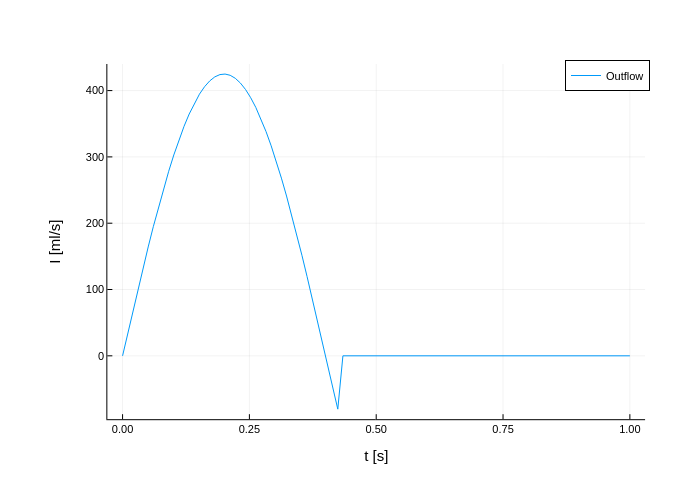

In [5]:
#| label: fig-igen
#| fig-cap: 'Generic waveform, representing ejection of blood from left ventricle in the aorta, including dicrotic notch (backflow at valve closure).'

plotTime = LinRange(0,1,100)

plot(plotTime, I.(plotTime),
     xlabel = "t [s]", ylabel = "I [ml/s]", label = "Outflow") 

The definition of the ODEs @eq-wk4-1 and @eq-wk4-2 is done as a function with parameters `dP` and `P`, for $\frac{d p_{1,2}}{d t}$, and $p_{1,2}$, respectively^[`P` is a vector of values, actually, as is `dP`.] 


In [6]:
#| output: false 
function wk4(dP, P, params, t)

    Rc, Rp, C, Lp = params

    dP[1] = (
        -Rc / Lp * P[1]
        + (Rc / Lp - 1 / Rp / C) * P[2]
        + Rc * ForwardDiff.derivative(I, t)
        + I(t) / C
        )

    dP[2] = -1 / Rp / C * P[2] + I(t) / C

    return dP[1], dP[2]

end

wk4 (generic function with 1 method)

We define the parameters, initial conditions, and time span for the integration:


In [7]:
Rc = 0.03
Rp = 1.0
C  = 2.0
Lp = 0.02

tspan = (0, 10)

params = [Rc, Rp, C, Lp]

P0 = zeros(2)

2-element Vector{Float64}:
 0.0
 0.0

And define the ODE problem and solve it^[We use the Dormand-Prince solver `DP5` here, because that is the same algorithm that Matlab's `ode45` uses. DifferentialEquations.jl has a multitude of other solvers that may perform better. Play around with these.]. We will time the run using the `@time` macro:


In [8]:
prob = ODEProblem(wk4, P0, tspan, params)

@time sol = solve(prob, DP5(), reltol=1e-9);

  3.934933 seconds (8.70 M allocations: 662.269 MiB, 9.89% gc time, 99.98% compilation time)


Looking at this run time, we see that the run is slower than the Matlab run^[See below. What happened here? Doesn't everybody say how much faster Julia is than Matlab?]. Looking at the details of the benchmark times, we see that most of that time has been used on compilation. So when we re-run the solver, it should take less time:


In [9]:
@time sol = solve(prob, DP5(), reltol=1e-9);

  0.000812 seconds (2.95 k allocations: 252.766 KiB)


And indeed, the run time is now one order of magnitude faster than the Matlab times shown in @sec-odePM.

We can plot the solution in @fig-wk4-sol using the special plot recipe for ODE solutions:


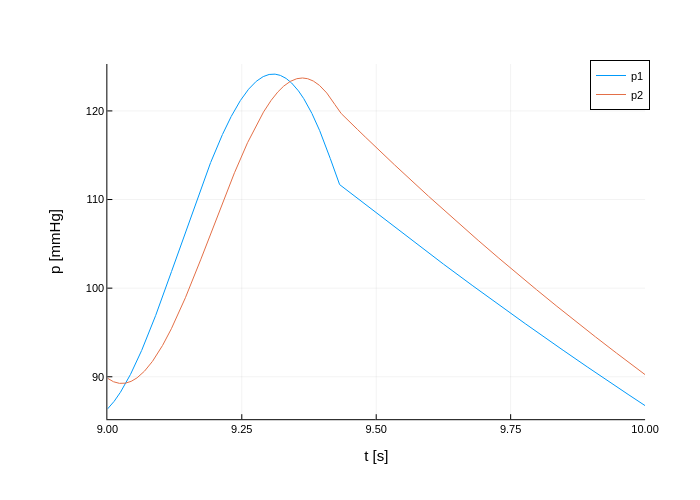

In [10]:
#| label: fig-wk4-sol
#| fig-cap: Solution of 4-element windkessel model using Julia's DifferentialEquations.jl
plot(sol,
     label = ["p1" "p2"],
     xlabel = "t [s]",
     ylabel = "p [mmHg]",
     tspan=(9,10))

### Comparison to Python and Matlab {#sec-odePM}

For those coming from Python or Matlab, let's have a look at how this problem can be solved in these two languages and compare to the Julia version.

Switch between the languages using the tabs below:

::: {.panel-tabset}
### Python


```python
import scipy as sp
from scipy import integrate
from scipy.misc import derivative

import numpy as np

import time

def wk4(t, y, I, Rc, Rp, C, Lp, dt):

    dp1dt = (
        -Rc / Lp * y[0]
        + (Rc / Lp - 1 / Rp / C) * y[1]
        + Rc * derivative(I, t, dx=dt)
        + I(t) / C
    )

    dp2dt = -1 / Rp / C * y[1] + I(t) / C

    return [dp1dt, dp2dt]

time_start = 0
time_end = 10

Rc = 0.2
Rp = 1.0
C = 1.0
Lp = 1e-2

dt = 1e-6

y0 = np.zeros(2)

# Generic Input Waveform
# max volume flow in ml/s
max_i = 425

# min volume flow in m^3/s
min_i = 0.0

# Period time in s
T = 0.9

# Syst. Time in s
systTime = 2 / 5 * T

# Dicrotic notch time
dicrTime = 0.03

def I(t):
    # implicit conditional using boolean multiplicator
    # sine waveform
    I = (
        (max_i - min_i) * np.sin(np.pi / systTime * (t % T))
        *(t % T < (systTime + dicrTime)) + min_i
    )

    return I

tic = time.perf_counter()

sol = sp.integrate.solve_ivp(
    lambda t, y: wk4(t, y, I, Rc, Rp, C, Lp, dt),
    (time_start, time_end),
    y0,
    method="RK45",
    rtol=1e-9,
    vectorized=True,) 

toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")
```

Runtime for this code is (timed using `%%time` in Jupyter):

```python
Time elapsed: 0.7872 seconds
```

### MATLAB

```octave
function dP = RHS_defn(t,P,Rc,Rp,C,Lp)

dP    = zeros(2,1);

dP(1) = -Rc / Lp * P(1) ...
        + (Rc / Lp - 1 / Rp / C) * P(2) ...
        + Rc * didt(t) + i(t) / C;

dP(2) = -1 / Rp / C * P(2) + i(t) / C;

end

function didt = didt(i, t)
dt = 1e-3;
didt = (i(t+dt) - i(t-dt)) / (2 * dt);
end

function i = i(t)

max_i = 425;
min_i = 0.0;
T = 0.9;

systTime = 2 / 5 * T;
dicrTime = 0.03;

i = ((max_i - min_i) * sin(pi / systTime * (mod(t,T))) ...
     *(mod(t,T) < (systTime + dicrTime)) ...
     + min_i);
end

Rc = 0.03
Rp = 1.0
C  = 2.0
Lp = 0.02

options = odeset('Reltol',1e-9);

tic
[t, P] = ode45(@(t,P) RHS_defn(t,P,Rc,Rp,C,Ls,Lp), tspan, P0, options);
toc
```

Runtime for this code is (timed using `tic` `toc` in Matlab)^[Same code in Octave, the free open-source version of Matlab runs in 3 seconds. Current versions of Matlab have improved runtime by partial just-in-time compilation. Note that the first run in Matlab is also slightly longer with 0.035 seconds, which is most likely due to Matlab optimising the solver to the problem.], which is a bit more than an order of magnitude slower than Julia:

```octave
Elapsed time is 0.018172 seconds.
```
:::

So in this case, Julia is one order of magitude faster than Matlab and around 500x faster than Python^[I have tried using PyPy and Cython in other cases and found that they speed up Python considerably. Unfortunately this was not the case when using SciPy and Numpy, which made the compiled Python version one order of magnitude **slower** than interpreted. There seems to be a problem with C-calls from PyPy.] solving ODEs.

Personally, I find the Matlab code and, in particular, the Julia code easier to read.
